In [1]:
import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score
from scikeras.wrappers import KerasClassifier
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
import os
import tensorflow as tf
from pathlib import Path

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full.shape


(60000, 28, 28)

In [3]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [4]:
y_train[0]

7

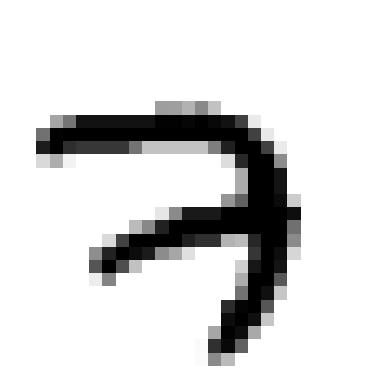

In [5]:
# Show the figure of the training set
import matplotlib.pyplot as plt
plt.imshow(X_train[0], cmap='binary')
plt.axis('off')
plt.show()

In [6]:
# Creating the mode
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

/Users/stefansanchez/miniconda3/envs/ivy_dev/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
optimizer = tf.keras.optimizers.SGD(learning_rate=3e-1)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [9]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 962us/step - accuracy: 0.8698 - loss: 0.4130 - val_accuracy: 0.9632 - val_loss: 0.1165
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 809us/step - accuracy: 0.9702 - loss: 0.0990 - val_accuracy: 0.9772 - val_loss: 0.0821
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step - accuracy: 0.9799 - loss: 0.0634 - val_accuracy: 0.9760 - val_loss: 0.0812
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step - accuracy: 0.9844 - loss: 0.0476 - val_accuracy: 0.9774 - val_loss: 0.0824
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 771us/step - accuracy: 0.9889 - loss: 0.0332 - val_accuracy: 0.9792 - val_loss: 0.0804
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 784us/step - accuracy: 0.9913 - loss: 0.0266 - val_accuracy: 0.9794 - val_loss: 0.0863
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 755us/step - accuracy: 0.9934 - loss: 0.0214 - val_accuracy: 0.9814 - val_loss: 0.0712
Epoch 8/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 785us/step - accuracy: 0.9956 -

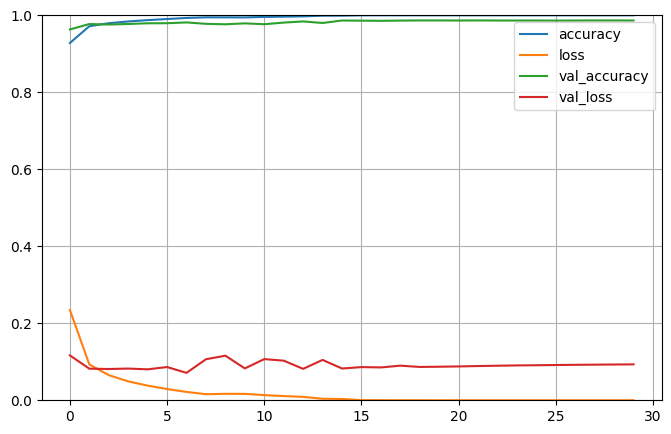

In [10]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [11]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.9795 - loss: 27.0681


[22.314912796020508, 0.9833999872207642]

We get 97.82% accuracy, but the target is 98+ for accuracy & precision. For this, we are going to use Early Stopping 

In [12]:
run_index = 1 # increment this at every run
run_logdir = Path() / "my_mnist_logs" / "run_{:03d}".format(run_index)
run_logdir

PosixPath('my_mnist_logs/run_001')

In [13]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_mnist_model.keras", save_best_only=True)


In [14]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 885us/step - accuracy: 1.0000 - loss: 2.8893e-05 - val_accuracy: 0.9864 - val_loss: 0.0935
Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 774us/step - accuracy: 1.0000 - loss: 2.8886e-05 - val_accuracy: 0.9862 - val_loss: 0.0939
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step - accuracy: 1.0000 - loss: 3.0936e-05 - val_accuracy: 0.9862 - val_loss: 0.0943
Epoch 4/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step - accuracy: 1.0000 - loss: 2.7767e-05 - val_accuracy: 0.9862 - val_loss: 0.0946
Epoch 5/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step - accuracy: 1.0000 - loss: 2.5497e-05 - val_accuracy: 0.9862 - val_loss: 0.0949
Epoch 6/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step - accuracy: 1.0000 - loss: 2.4693e-05 - val_accuracy: 0.9862 - val_loss: 0.0952
Epoch 7/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 802us/step - accuracy: 1.0000 - loss: 2.3512e-05 - val_accuracy: 0.9862 - val_loss: 0.0955
Epoch 8/100
1719/1719 ━━━━━━━━━━━━━━━━━━━

In [15]:
model = tf.keras.models.load_model("my_mnist_model.keras") # rollback to best model
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.9798 - loss: 27.1546 


[22.379474639892578, 0.9835000038146973]

In [16]:
# Predict on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate precision
precision = precision_score(y_test, y_pred_classes, average=None)
precision_total = sum(precision)/len(precision)
print("precision: ", precision_total)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step
precision:  0.9835325101681522
